In [1]:
!which python

/Users/shibinhoo/miniconda3/envs/benchmark/bin/python


# Preparation

## Dataset

In [2]:
# Read all dataset configs from point_forecast.yaml
import yaml

POINT_FORECAST_CONFIG = "resources/benchmarks/point_forecast.yaml"

with open(POINT_FORECAST_CONFIG) as file:
    raw_config = yaml.load(file, Loader=yaml.FullLoader)

config = {}
for c in raw_config:
    config[c["name"]] = c

config.keys()

dict_keys(['car_parts', 'cif_2016', 'covid_deaths', 'electricity_hourly', 'electricity_weekly', 'fred_md', 'hospital', 'kdd_cup_2018', 'm1_monthly', 'm1_quarterly', 'm1_yearly', 'm3_monthly', 'm3_other', 'm3_quarterly', 'm3_yearly', 'm4_daily', 'm4_hourly', 'm4_weekly', 'm4_yearly', 'm4_monthly', 'm4_quarterly', 'nn5_daily', 'nn5_weekly', 'pedestrian_counts', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'vehicle_trips', 'web_traffic_weekly'])

In [3]:
selected_dataset = [
    "kdd_cup_2018",     # SN and TabPFN both did well
    "cif_2016",
    "fred_md",
    "m1_yearly",
    "m4_hourly",        # SN did well, TabPFN suffered
    "m4_weekly",
    "m4_yearly",        # SN and TabPFN both did okay
    "covid_deaths",      # SN and TabPFN both suffered
]

# assert all selected datasets are in the config
for d in selected_dataset:
    assert d in config, f"{d} not in config"

In [4]:
# Load all datasets
from tqdm import tqdm
from amlb.datasets.file import TimeSeriesDataset
from amlb.utils.core import Namespace
from frameworks.shared.utils import load_timeseries_dataset
from concurrent.futures import ThreadPoolExecutor, as_completed


datasets = {}

def fetch_dataset(dataset_config: dict[str, any]):
    name = dataset_config["name"]
    d_config = dataset_config["dataset"]
    print(f"Loading {name}")

    dataset = TimeSeriesDataset(
        path=d_config["path"],
        fold=0,
        target=d_config["target"],
        features="timestamp",
        cache_dir="./tmp_cache",
        config=Namespace(d_config | {"name": name}),
    )

    dataset.train_path = dataset.train.path
    dataset.test_path = dataset.test.path

    train_df, test_df = load_timeseries_dataset(dataset)

    print(f"Loading {name} done.")
    return name, {"train": train_df, "test": test_df}


with ThreadPoolExecutor(max_workers=4) as executor:
    futures = [executor.submit(fetch_dataset, config[d]) for d in selected_dataset]
    for future in tqdm(as_completed(futures), total=len(selected_dataset)):
        name, dataset = future.result()
        datasets[name] = dataset

/Users/shibinhoo/miniconda3/envs/benchmark/lib/python3.10/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Loading kdd_cup_2018Loading cif_2016

Loading fred_md
Loading m1_yearly


 12%|█▎        | 1/8 [00:00<00:00,  9.33it/s]

Loading m1_yearly done.
Loading m4_hourly
Loading cif_2016 done.
Loading m4_weekly


 38%|███▊      | 3/8 [00:00<00:00,  5.06it/s]

Loading fred_md done.
Loading m4_yearly


 50%|█████     | 4/8 [00:03<00:04,  1.16s/it]

Loading m4_weekly done.
Loading covid_deaths


 62%|██████▎   | 5/8 [00:03<00:02,  1.08it/s]

Loading m4_hourly done.


 75%|███████▌  | 6/8 [00:04<00:01,  1.41it/s]

Loading covid_deaths done.


 88%|████████▊ | 7/8 [00:06<00:01,  1.22s/it]

Loading m4_yearly done.


100%|██████████| 8/8 [00:11<00:00,  1.39s/it]

Loading kdd_cup_2018 done.


In [5]:
# Examine the datasets
for d, val in datasets.items():
    print(f"{d}: {val['train'].shape} {val['test'].shape}")

m1_yearly: (3429, 3) (1086, 3)
cif_2016: (6244, 3) (864, 3)
fred_md: (76612, 3) (1284, 3)
m4_weekly: (366912, 3) (4667, 3)
m4_hourly: (353500, 3) (19872, 3)
covid_deaths: (48412, 3) (7980, 3)
m4_yearly: (707265, 3) (137844, 3)
kdd_cup_2018: (2929404, 3) (12960, 3)


In [25]:
datasets["cif_2016"]["train"][datasets["cif_2016"]["train"]["item_id"] == "65"].shape



(61, 3)

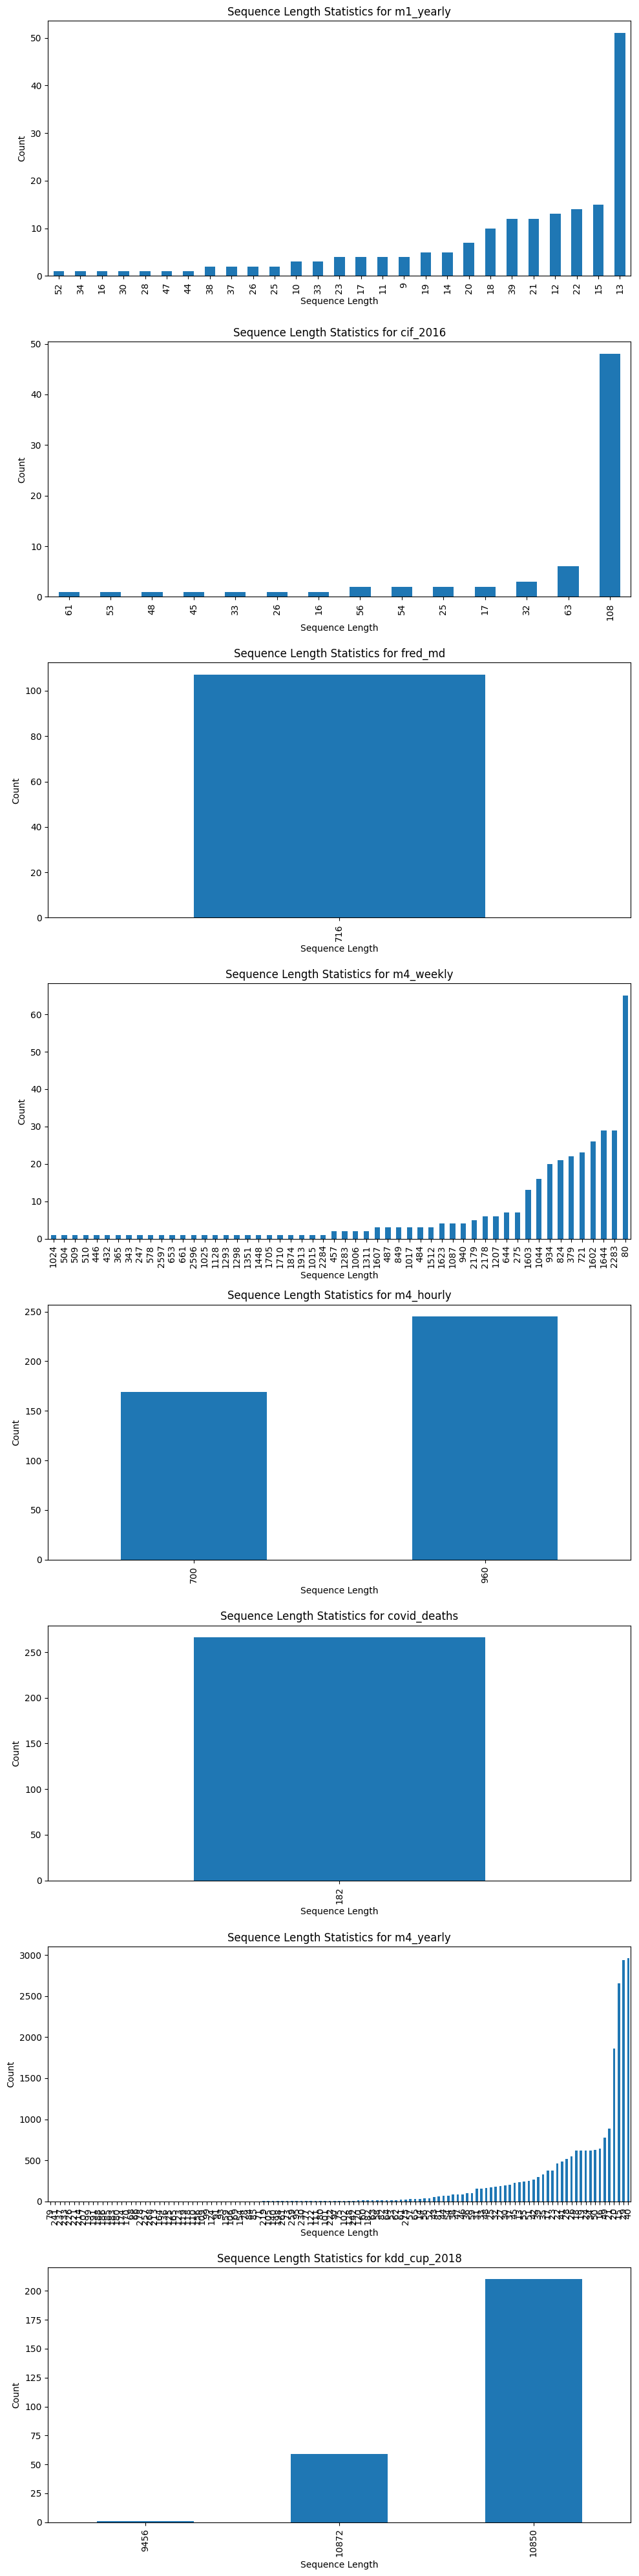

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize a figure for plotting
fig, axes = plt.subplots(nrows=len(datasets), ncols=1, figsize=(10, 5 * len(datasets)))
if len(datasets) == 1:
    axes = [axes]  # Ensure axes is always a list for consistency in single dataset case

# Iterate over each dataset to perform analysis and visualization
for ax, (dataset_name, dataset) in zip(axes, datasets.items()):
    # Count the total number of appearances of each item_id in the current dataset using pandas
    item_id_counts = dataset["train"]["item_id"].value_counts()

    # Count the frequency of each total number of appearances
    appearance_count_frequency = item_id_counts.value_counts()

    # Create a DataFrame to display the summary of total number of appearances and their respective counts
    summary_df = pd.DataFrame({
        'Count': appearance_count_frequency.index,
        'Sequence Length': appearance_count_frequency.values
    })

    # Sort the DataFrame by 'Sequence Length' for plotting
    summary_df = summary_df.sort_values(by='Sequence Length')

    # Plotting the sorted summary DataFrame
    summary_df.plot(kind='bar', x='Count', y='Sequence Length', ax=ax, legend=False)
    ax.set_title(f"Sequence Length Statistics for {dataset_name}")
    ax.set_xlabel("Sequence Length")
    ax.set_ylabel("Count")

# Adjust layout
plt.tight_layout()
plt.show()



In [5]:
LIMIT_NUM_SERIES = 2

In [6]:
# for each dataset, only select 2 series (identified by item_id)
datasets_by_item_id = {}
for name, dataset in datasets.items():
    train_df = dataset["train"]
    test_df = dataset["test"]
    item_ids = train_df.item_id.unique()
    datasets_by_item_id[name] = {}
    for item_id in item_ids[:LIMIT_NUM_SERIES]:
        sub_train_df = train_df[train_df.item_id == item_id].drop(columns=["item_id"])
        sub_test_df = test_df[test_df.item_id == item_id].drop(columns=["item_id"])
        datasets_by_item_id[name][item_id] = {"train": sub_train_df, "test": sub_test_df}


In [7]:
# print layout of datasets_by_item_id
for name, items in datasets_by_item_id.items():
    print(name)
    for item_id, dataset in items.items():
        print(f"  item_id {item_id}: {dataset['train'].shape[0]} rows in train, {dataset['test'].shape[0]} rows in test")

m1_yearly
  item_id 0: 22 rows in train, 6 rows in test
  item_id 1: 23 rows in train, 6 rows in test
cif_2016
  item_id 0: 108 rows in train, 12 rows in test
  item_id 1: 108 rows in train, 12 rows in test
fred_md
  item_id 0: 716 rows in train, 12 rows in test
  item_id 1: 716 rows in train, 12 rows in test
m4_weekly
  item_id 0: 2179 rows in train, 13 rows in test
  item_id 1: 1710 rows in train, 13 rows in test
m4_hourly
  item_id 0: 700 rows in train, 48 rows in test
  item_id 1: 700 rows in train, 48 rows in test
covid_deaths
  item_id 0: 182 rows in train, 30 rows in test
  item_id 1: 182 rows in train, 30 rows in test
m4_yearly
  item_id 0: 31 rows in train, 6 rows in test
  item_id 1: 31 rows in train, 6 rows in test
kdd_cup_2018
  item_id 0: 10850 rows in train, 48 rows in test
  item_id 1: 10850 rows in train, 48 rows in test


## Utils (data preprocessing, evaluation etc.)

In [8]:
def split_time_series_to_X_y(df, target_col="target"):
    X = df.drop(columns=[target_col])
    y = df[target_col]    
    return X, y

In [9]:
import matplotlib.pyplot as plt

def plot_data(X_train, y_train, X_test, y_test, train_pred, test_pred, title=None):
    plt.figure(figsize=(12, 4))
    plt.plot(X_train.timestamp, y_train, label="train")
    plt.plot(X_test.timestamp, y_test, label="test")
    plt.plot(X_train.timestamp, train_pred, label="train_pred", linestyle="--")
    plt.plot(X_test.timestamp, test_pred, label="test_pred")
    plt.legend()
    
    if title:
        plt.title(title)
        
    plt.show()

In [10]:
import torch
from tabpfn import TabPFNRegressor

model = TabPFNRegressor(device=("cuda" if torch.cuda.is_available() else "cpu"))

def evaluate(add_time_series_feature: callable = None, datasets=datasets_by_item_id, model=model):
    for d in datasets:
        for item_id in datasets[d]:
            print(f"Evaluating on {d} item_id {item_id}")

            train_df = datasets[d][item_id]["train"]
            test_df = datasets[d][item_id]["test"]
            
            if add_time_series_feature:
                train_df, test_df = add_time_series_feature(train_df, test_df)
            
            X_train, y_train = split_time_series_to_X_y(train_df)
            X_test, y_test = split_time_series_to_X_y(test_df)
            
            model.fit(X_train, y_train)
            train_pred = model.predict(X_train)
            test_pred = model.predict(X_test)
            
            plot_data(X_train, y_train, X_test, y_test, train_pred, test_pred, title=f"{d} item_id {item_id}")

# Experiments & Evaluations

## Vanilla TabPFN

Evaluating on m1_yearly item_id 0
Loading checkpoint from /work/dlclarge1/hoos-time/miniforge3/envs/tabpfn/lib/python3.10/site-packages/tabpfn/model_cache/model_hans_regression.ckpt
Preprocessing config in new way
removed num_classes from differentiable_hyperparameters
Initializing Bar distribution
remove your triton_ln config, it is now parameter_free as default.
Initialized decoder for standard with (None, 5000)  and nout 5000
using feature positional embedding subspace
failed to fit feature with error ValueError("Input X contains infinity or a value too large for dtype('float32').") skipping
cancel nan borders


Training + Prediction Passes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.11batch/s]


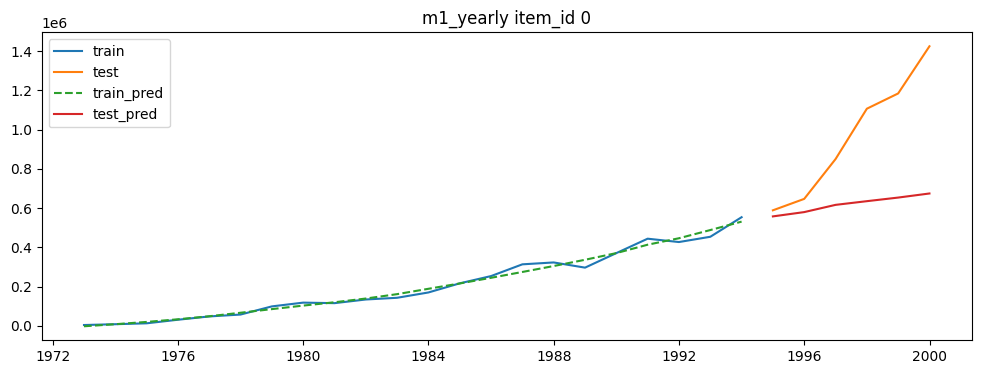

Evaluating on m1_yearly item_id 1


Training + Prediction Passes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.71batch/s]


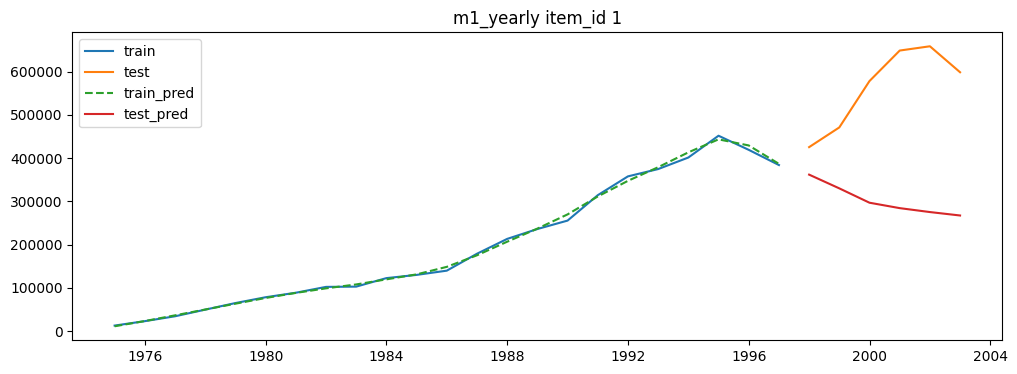

Evaluating on cif_2016 item_id 0


Training + Prediction Passes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.68batch/s]


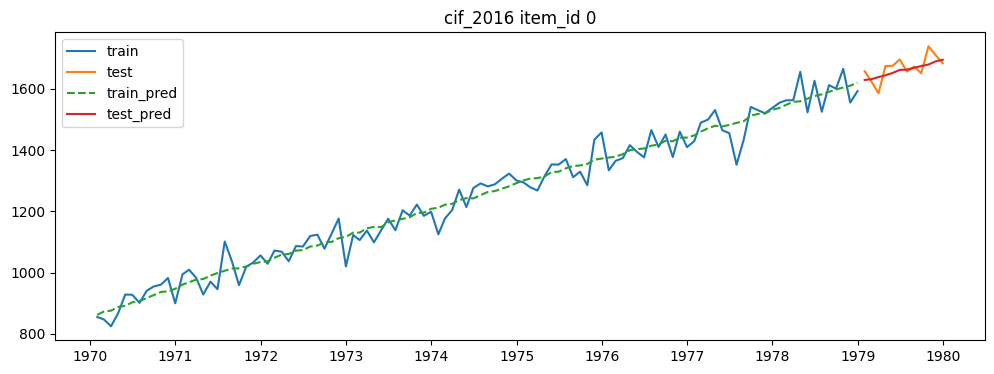

Evaluating on cif_2016 item_id 1


Training + Prediction Passes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.75batch/s]


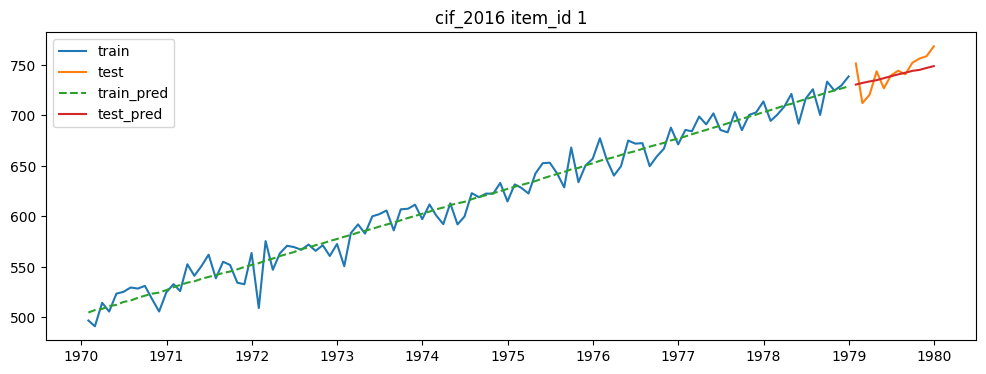

Evaluating on fred_md item_id 0


Training + Prediction Passes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.32batch/s]


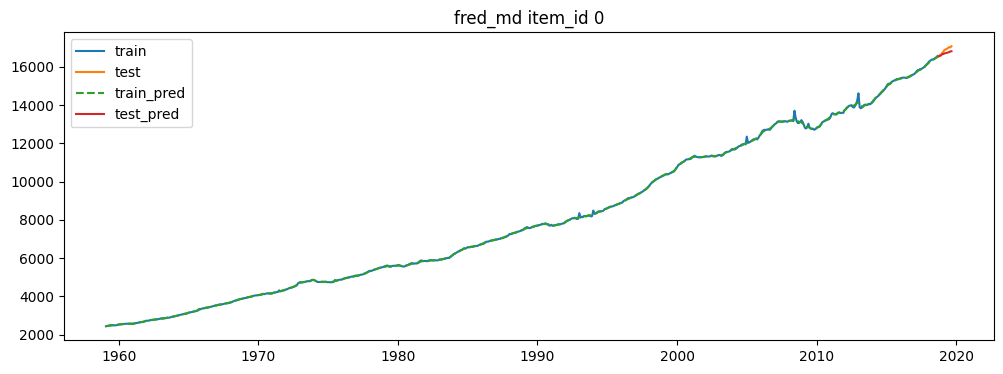

Evaluating on fred_md item_id 1


Training + Prediction Passes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.33batch/s]


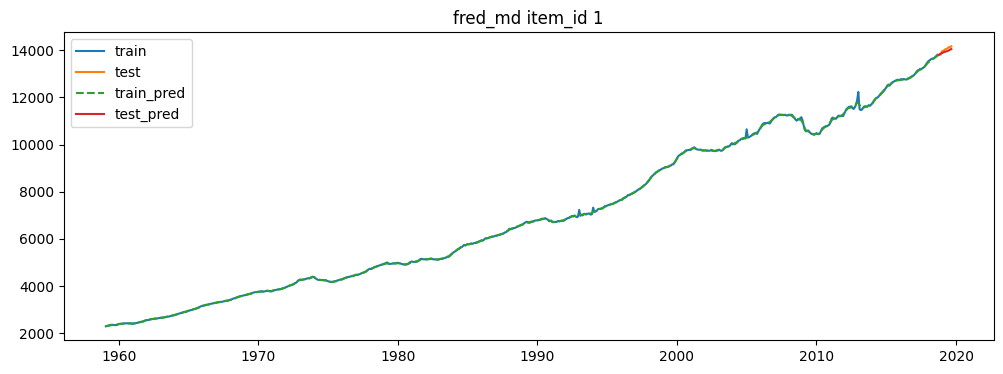

Evaluating on m4_hourly item_id 0


Training + Prediction Passes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.31batch/s]


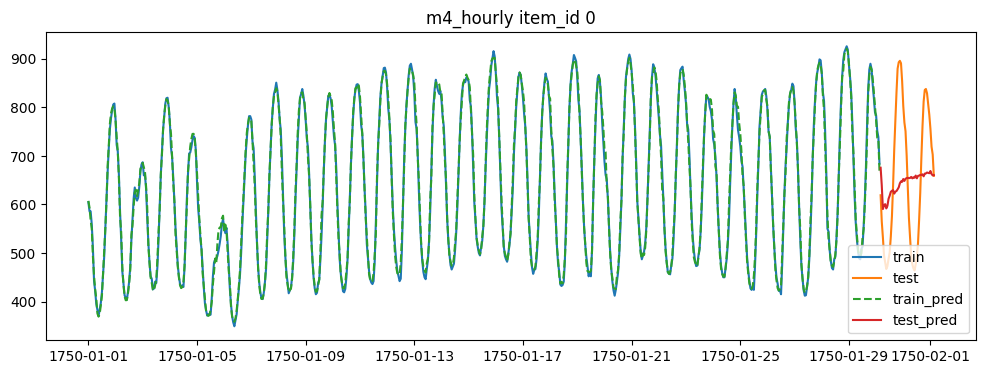

Evaluating on m4_hourly item_id 1


Training + Prediction Passes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.31batch/s]


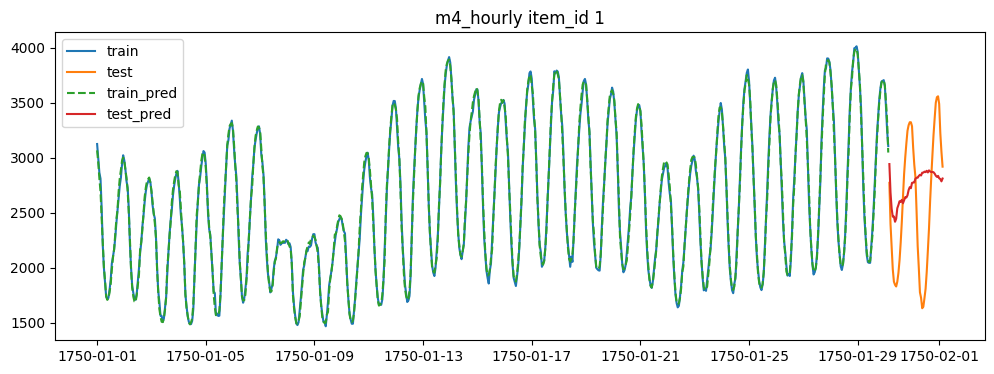

Evaluating on m4_weekly item_id 0


Training + Prediction Passes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.12batch/s]


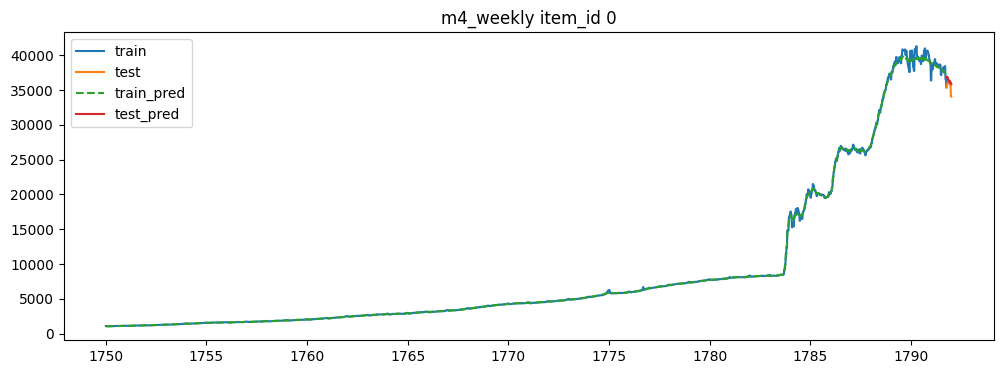

Evaluating on m4_weekly item_id 1


Training + Prediction Passes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.08batch/s]


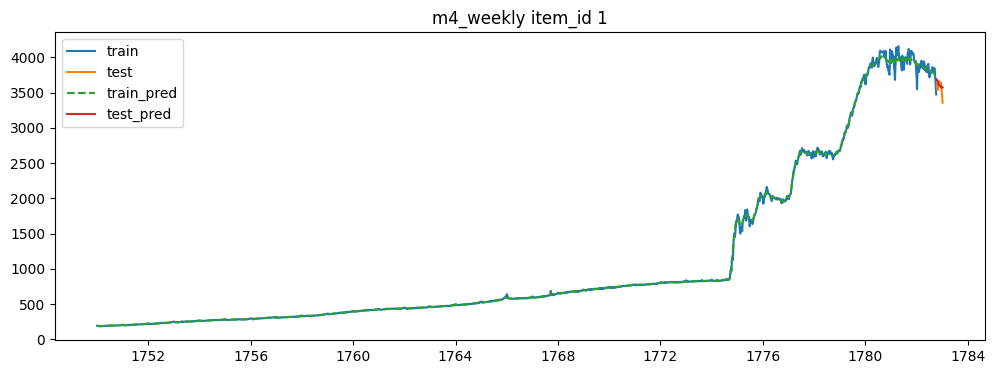

Evaluating on covid_deaths item_id 0


Training + Prediction Passes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.73batch/s]


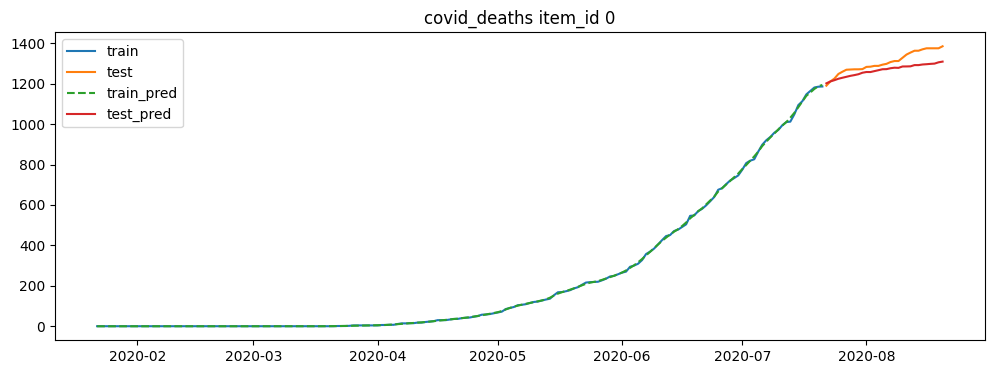

Evaluating on covid_deaths item_id 1


Training + Prediction Passes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.75batch/s]


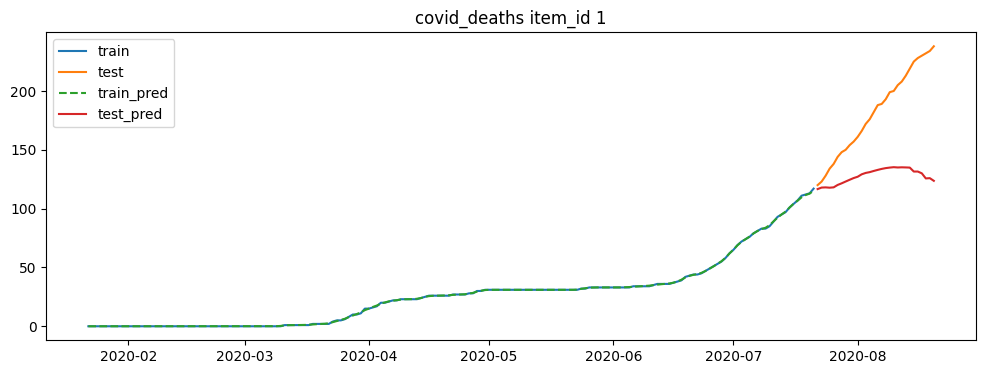

Evaluating on m4_yearly item_id 0


Training + Prediction Passes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.74batch/s]


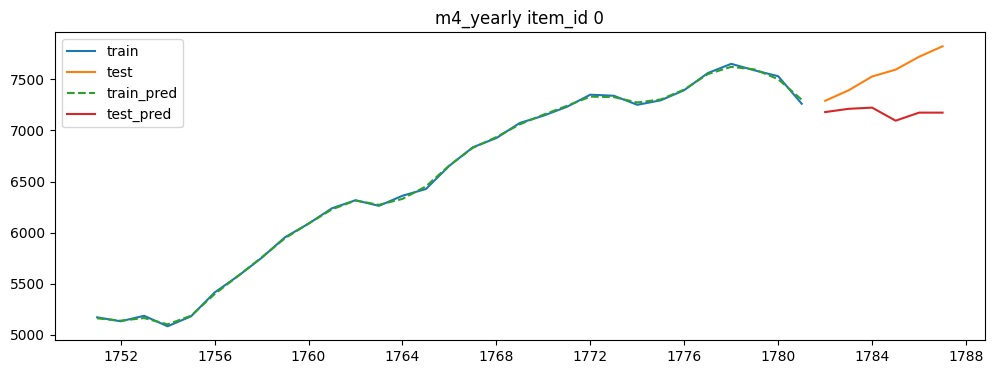

Evaluating on m4_yearly item_id 1


Training + Prediction Passes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.72batch/s]


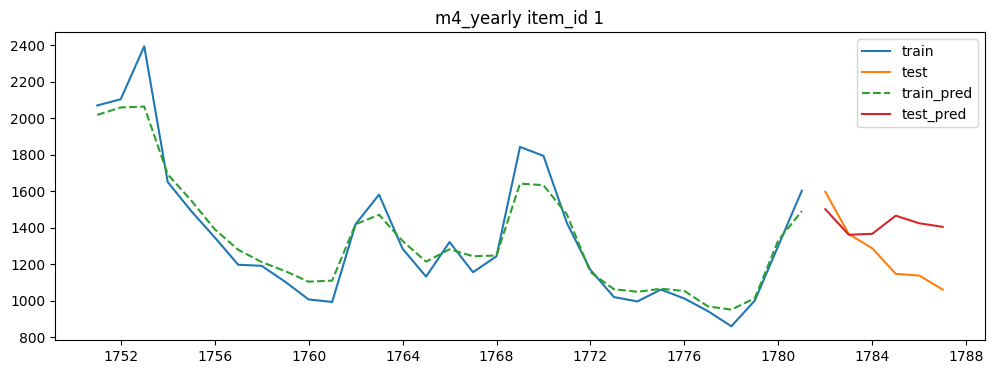

Evaluating on kdd_cup_2018 item_id 0


Training + Prediction Passes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.03batch/s]


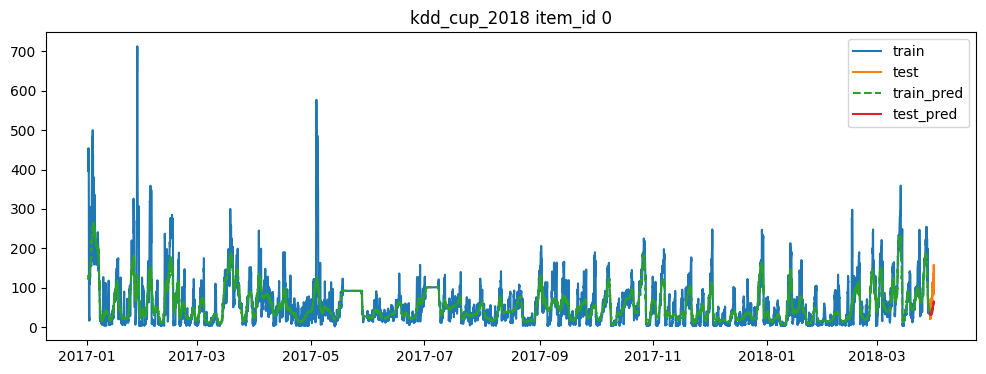

Evaluating on kdd_cup_2018 item_id 1


Training + Prediction Passes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.02batch/s]


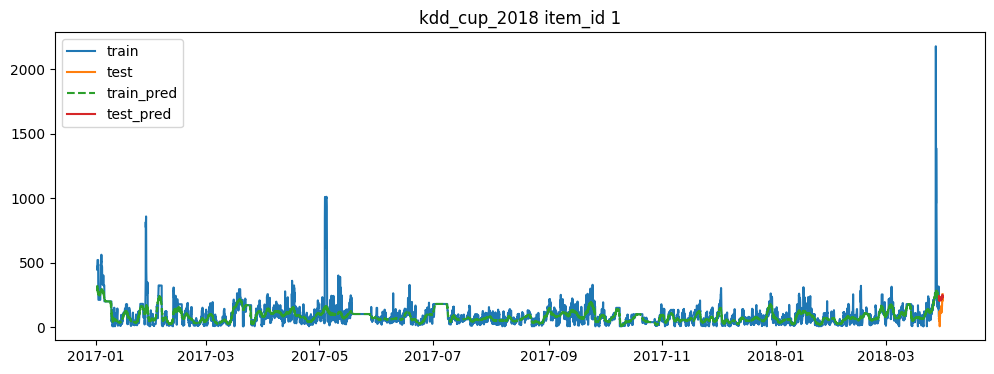

In [17]:
# Evaluate the model without adding time series features
evaluate()

## TabPFN + Time-Series Features

In [18]:
# Common transformation for both train and test data
import pandas as pd
import numpy as np

def add_time_series_feature(
        train_data: pd.DataFrame,
        test_data: pd.DataFrame,
        target_col="target"
):
    # Hack (for hourly data): Add hour of the day as a relative feature
    for data in [train_data, test_data]:
        data["hour"] = train_data.timestamp.dt.hour
        data["day_of_week"] = train_data.timestamp.dt.isocalendar().day
        data["day_of_month"] = train_data.timestamp.dt.day
        data["day_of_year"] = train_data.timestamp.dt.dayofyear
        data["month"] = train_data.timestamp.dt.month
        data["year"] = train_data.timestamp.dt.year
        data["week_of_year"] = train_data.timestamp.dt.isocalendar().week
        data["quarter"] = train_data.timestamp.dt.quarter

    # Convert timestamp from datetime64 to int (number of hours since the first timestamp)
    ref_timestamp = train_data["timestamp"].min()
    train_data["timestamp"] = (train_data["timestamp"] - ref_timestamp).dt.total_seconds() / 3600
    test_data["timestamp"] = (test_data["timestamp"] - ref_timestamp).dt.total_seconds() / 3600

    # Add sin and cos components with different periods
    def add_trigonometric_features(df, max_period):
        # Precompute all sine and cosine columns for the dataframe
        # sin_cols = {}
        # cos_cols = {}
        # for period in range(1, max_period):
        #     print("period", period)
        #     sin_cols = {f"sin_{period}": np.sin(2 * np.pi * df.timestamp / period)}
        #     cos_cols = {f"cos_{period}": np.cos(2 * np.pi * df.timestamp / period)}

        sin_cols = {f'sin_{period}': np.sin(2 * np.pi * df.timestamp / period) for period in range(1, max_period)}
        cos_cols = {f'cos_{period}': np.cos(2 * np.pi * df.timestamp / period) for period in range(1, max_period)}

        new_cols = {**sin_cols, **cos_cols}

        # Convert dict to Dataframe and concatenate to the original dataframe
        new_cols_df = pd.DataFrame(new_cols)
        return pd.concat([df, new_cols_df], axis=1)

    MAX_PERIOD = 240
    train_data = add_trigonometric_features(train_data, MAX_PERIOD)
    test_data = add_trigonometric_features(test_data, MAX_PERIOD)
            
    # Add lagged features
    LAG_MAX = test_data.shape[0]
    for lag in range(1, LAG_MAX):
        train_data[f'lag_{lag}'] = train_data[target_col].shift(lag)
        
        # Test data should not have lagged features for the future
        if test_data is not None:
            test_data[f'lag_{lag}'] = np.nan
            test_data.loc[test_data.index[:lag], f'lag_{lag}'] = \
                train_data[target_col].iloc[-lag:].values

    return train_data, test_data


In [19]:
h1_train = train_df[train_df.item_id == "H1"].drop(columns=["item_id"])
h1_test = test_df[test_df.item_id == "H1"].drop(columns=["item_id"])

In [20]:
# Common transformation for both train and test data
import pandas as pd
import numpy as np

def add_time_series_feature(
        train_data: pd.DataFrame,
        test_data: pd.DataFrame,
        target_col="target"
):
    # Hack (for hourly data): Add hour of the day as a relative feature
    for data in [train_data, test_data]:
        data["hour"] = train_data.timestamp.dt.hour
        data["day_of_week"] = train_data.timestamp.dt.isocalendar().day
        data["day_of_month"] = train_data.timestamp.dt.day
        data["day_of_year"] = train_data.timestamp.dt.dayofyear
        data["month"] = train_data.timestamp.dt.month
        data["year"] = train_data.timestamp.dt.year
        data["week_of_year"] = train_data.timestamp.dt.isocalendar().week
        data["quarter"] = train_data.timestamp.dt.quarter

    # Convert timestamp from datetime64 to int (number of hours since the first timestamp)
    ref_timestamp = train_data["timestamp"].min()
    train_data["timestamp"] = (train_data["timestamp"] - ref_timestamp).dt.total_seconds() / 3600
    test_data["timestamp"] = (test_data["timestamp"] - ref_timestamp).dt.total_seconds() / 3600

    # Add sin and cos components with different periods
    def add_trigonometric_features(df, max_period):
        # Precompute all sine and cosine columns for the dataframe
        # sin_cols = {}
        # cos_cols = {}
        # for period in range(1, max_period):
        #     print("period", period)
        #     sin_cols = {f"sin_{period}": np.sin(2 * np.pi * df.timestamp / period)}
        #     cos_cols = {f"cos_{period}": np.cos(2 * np.pi * df.timestamp / period)}

        sin_cols = {f'sin_{period}': np.sin(2 * np.pi * df.timestamp / period) for period in range(1, max_period)}
        cos_cols = {f'cos_{period}': np.cos(2 * np.pi * df.timestamp / period) for period in range(1, max_period)}

        new_cols = {**sin_cols, **cos_cols}

        # Convert dict to Dataframe and concatenate to the original dataframe
        new_cols_df = pd.DataFrame(new_cols)
        return pd.concat([df, new_cols_df], axis=1)

    MAX_PERIOD = 240
    train_data = add_trigonometric_features(train_data, MAX_PERIOD)
    test_data = add_trigonometric_features(test_data, MAX_PERIOD)
            
    # Add lagged features
    LAG_MAX = test_data.shape[0]
    for lag in range(1, LAG_MAX):
        train_data[f'lag_{lag}'] = train_data[target_col].shift(lag)
        
        # Test data should not have lagged features for the future
        if test_data is not None:
            test_data[f'lag_{lag}'] = np.nan
            test_data.loc[test_data.index[:lag], f'lag_{lag}'] = \
                train_data[target_col].iloc[-lag:].values

    return train_data, test_data


In [21]:
h1_train, h1_test = add_time_series_feature(h1_train, h1_test)

In [22]:
# Show the data without collapsing the output
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(h1_train.head(20))
# h1_train.head(50)

,timestamp,target,hour,day_of_week,day_of_month,day_of_year,month,year,week_of_year,quarter,sin_1,sin_2,sin_3,sin_4,sin_5,sin_6,sin_7,sin_8,sin_9,sin_10,sin_11,sin_12,sin_13,sin_14,sin_15,sin_16,sin_17,sin_18,sin_19,sin_20,sin_21,sin_22,sin_23,sin_24,sin_25,sin_26,sin_27,sin_28,sin_29,sin_30,sin_31,sin_32,sin_33,sin_34,sin_35,sin_36,sin_37,sin_38,sin_39,sin_40,sin_41,sin_42,sin_43,sin_44,sin_45,sin_46,sin_47,sin_48,sin_49,sin_50,sin_51,sin_52,sin_53,sin_54,sin_55,sin_56,sin_57,sin_58,sin_59,sin_60,sin_61,sin_62,sin_63,sin_64,sin_65,sin_66,sin_67,sin_68,sin_69,sin_70,sin_71,sin_72,sin_73,sin_74,sin_75,sin_76,sin_77,sin_78,sin_79,sin_80,sin_81,sin_82,sin_83,sin_84,sin_85,sin_86,sin_87,sin_88,sin_89,sin_90,sin_91,sin_92,sin_93,sin_94,sin_95,sin_96,sin_97,sin_98,sin_99,sin_100,sin_101,sin_102,sin_103,sin_104,sin_105,sin_106,sin_107,sin_108,sin_109,sin_110,sin_111,sin_112,sin_113,sin_114,sin_115,sin_116,sin_117,sin_118,sin_119,sin_120,sin_121,sin_122,sin_123,sin_124,sin_125,sin_126,sin_127,sin_128,sin_129,sin_130,sin_131,sin_132,sin_133,sin_134,sin_135,sin_136,sin_137,sin_138,sin_139,sin_140,sin_141,sin_142,sin_143,sin_144,sin_145,sin_146,sin_147,sin_148,sin_149,sin_150,sin_151,sin_152,sin_153,sin_154,sin_155,sin_156,sin_157,sin_158,sin_159,sin_160,sin_161,sin_162,sin_163,sin_164,sin_165,sin_166,sin_167,sin_168,sin_169,sin_170,sin_171,sin_172,sin_173,sin_174,sin_175,sin_176,sin_177,sin_178,sin_179,sin_180,sin_181,sin_182,sin_183,sin_184,sin_185,sin_186,sin_187,sin_188,sin_189,sin_190,sin_191,sin_192,sin_193,sin_194,sin_195,sin_196,sin_197,sin_198,sin_199,sin_200,sin_201,sin_202,sin_203,sin_204,sin_205,sin_206,sin_207,sin_208,sin_209,sin_210,sin_211,sin_212,sin_213,sin_214,sin_215,sin_216,sin_217,sin_218,sin_219,sin_220,sin_221,sin_222,sin_223,sin_224,sin_225,sin_226,sin_227,sin_228,sin_229,sin_230,sin_231,sin_232,sin_233,sin_234,sin_235,sin_236,sin_237,sin_238,sin_239,cos_1,cos_2,cos_3,cos_4,cos_5,cos_6,cos_7,cos_8,cos_9,cos_10,cos_11,cos_12,cos_13,cos_14,cos_15,cos_16,cos_17,cos_18,cos_19,cos_20,cos_21,cos_22,cos_23,cos_24,cos_25,cos_26,cos_27,cos_28,cos_29,cos_30,cos_31,cos_32,cos_33,cos_34,cos_35,cos_36,cos_37,cos_38,cos_39,cos_40,cos_41,cos_42,cos_43,cos_44,cos_45,cos_46,cos_47,cos_48,cos_49,cos_50,cos_51,cos_52,cos_53,cos_54,cos_55,cos_56,cos_57,cos_58,cos_59,cos_60,cos_61,cos_62,cos_63,cos_64,cos_65,cos_66,cos_67,cos_68,cos_69,cos_70,cos_71,cos_72,cos_73,cos_74,cos_75,cos_76,cos_77,cos_78,cos_79,cos_80,cos_81,cos_82,cos_83,cos_84,cos_85,cos_86,cos_87,cos_88,cos_89,cos_90,cos_91,cos_92,cos_93,cos_94,cos_95,cos_96,cos_97,cos_98,cos_99,cos_100,cos_101,cos_102,cos_103,cos_104,cos_105,cos_106,cos_107,cos_108,cos_109,cos_110,cos_111,cos_112,cos_113,cos_114,cos_115,cos_116,cos_117,cos_118,cos_119,cos_120,cos_121,cos_122,cos_123,cos_124,cos_125,cos_126,cos_127,cos_128,cos_129,cos_130,cos_131,cos_132,cos_133,cos_134,cos_135,cos_136,cos_137,cos_138,cos_139,cos_140,cos_141,cos_142,cos_143,cos_144,cos_145,cos_146,cos_147,cos_148,cos_149,cos_150,cos_151,cos_152,cos_153,cos_154,cos_155,cos_156,cos_157,cos_158,cos_159,cos_160,cos_161,cos_162,cos_163,cos_164,cos_165,cos_166,cos_167,cos_168,cos_169,cos_170,cos_171,cos_172,cos_173,cos_174,cos_175,cos_176,cos_177,cos_178,cos_179,cos_180,cos_181,cos_182,cos_183,cos_184,cos_185,cos_186,cos_187,cos_188,cos_189,cos_190,cos_191,cos_192,cos_193,cos_194,cos_195,cos_196,cos_197,cos_198,cos_199,cos_200,cos_201,cos_202,cos_203,cos_204,cos_205,cos_206,cos_207,cos_208,cos_209,cos_210,cos_211,cos_212,cos_213,cos_214,cos_215,cos_216,cos_217,cos_218,cos_219,cos_220,cos_221,cos_222,cos_223,cos_224,cos_225,cos_226,cos_227,cos_228,cos_229,cos_230,cos_231,cos_232,cos_233,cos_234,cos_235,cos_236,cos_237,cos_238,cos_239


In [23]:
# plot sin_x against the timestamp
plt.figure(figsize=(12, 6))

# set tick of 24 hours
plt.xticks(np.arange(0, h1_train.timestamp.max(), 24))

plt.plot(h1_train.timestamp, h1_train.sin_24, label="sin_24")
plt.plot(h1_train.timestamp, h1_train.sin_48, label="sin_48")

plt.legend()


ValueError: arange: cannot compute length

<Figure size 1200x600 with 0 Axes>

Evaluating on m1_yearly item_id 0


Training + Prediction Passes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.18batch/s]


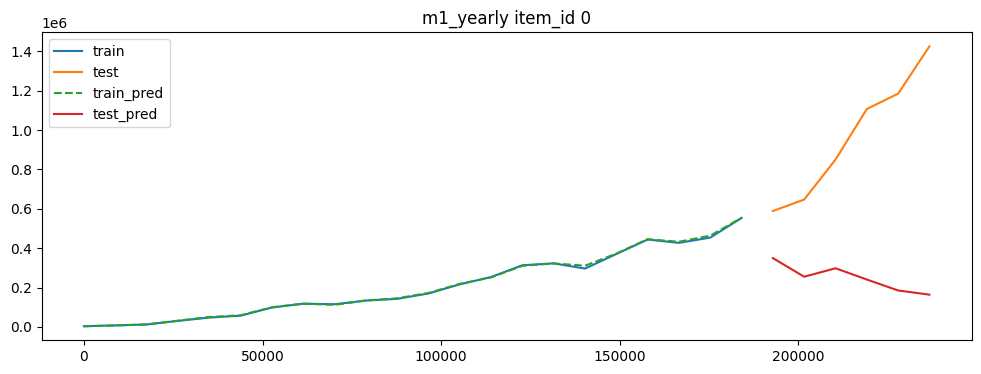

Evaluating on m1_yearly item_id 1


Training + Prediction Passes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.15batch/s]


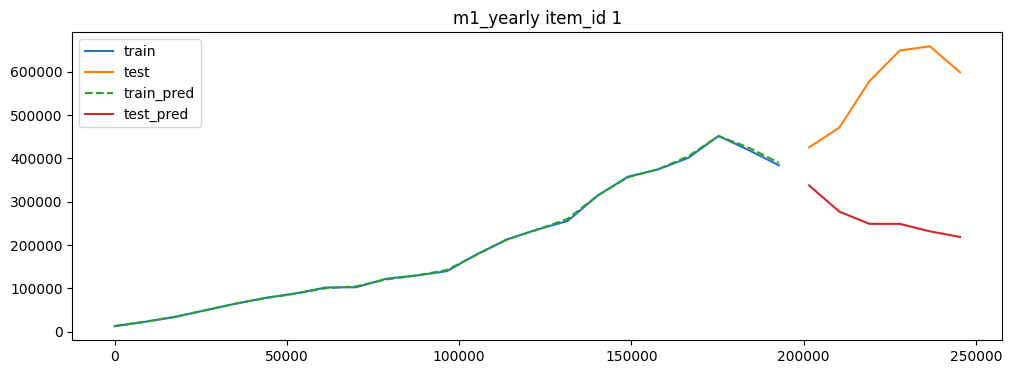

Evaluating on cif_2016 item_id 0


Training + Prediction Passes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.08batch/s]


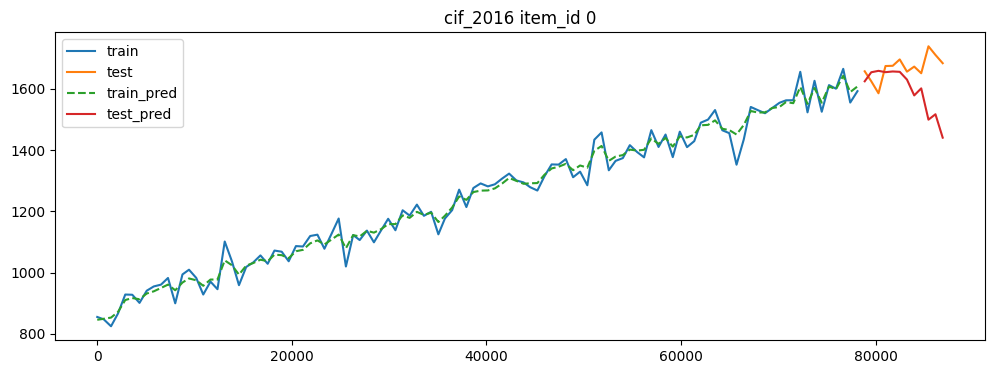

Evaluating on cif_2016 item_id 1


Training + Prediction Passes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.08batch/s]


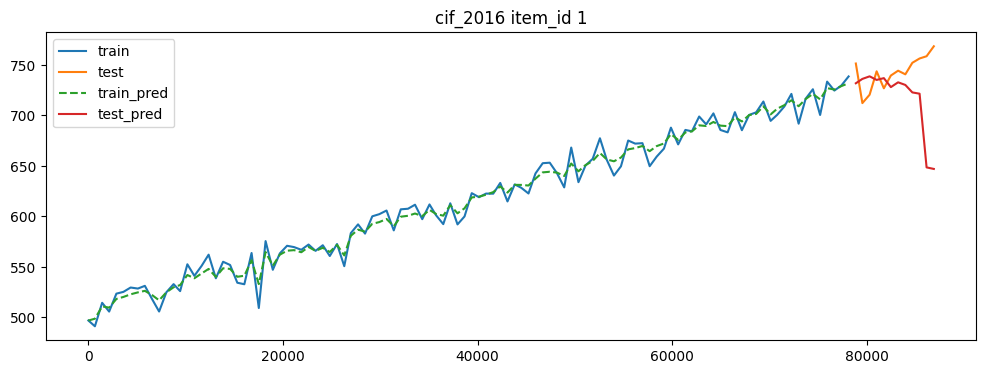

Evaluating on fred_md item_id 0


Training + Prediction Passes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.61batch/s]


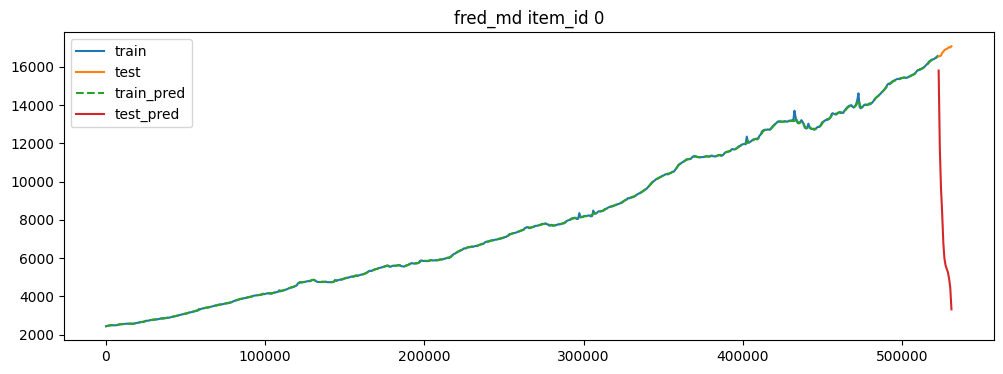

Evaluating on fred_md item_id 1


Training + Prediction Passes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.61batch/s]


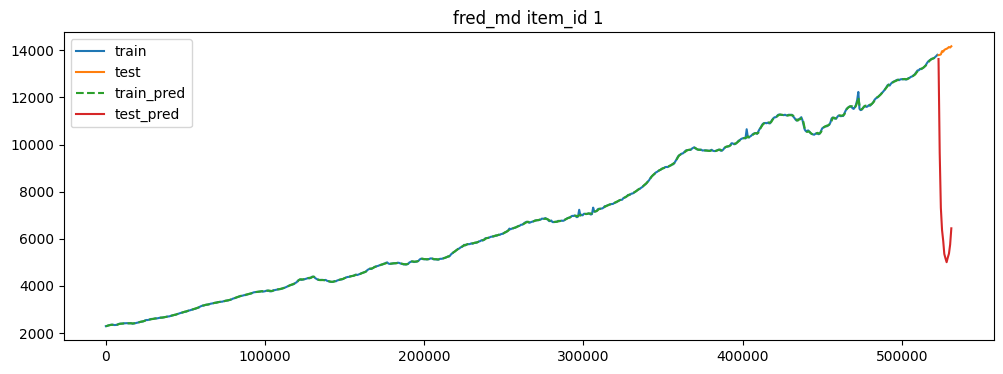

Evaluating on m4_hourly item_id 0


Training + Prediction Passes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.55batch/s]


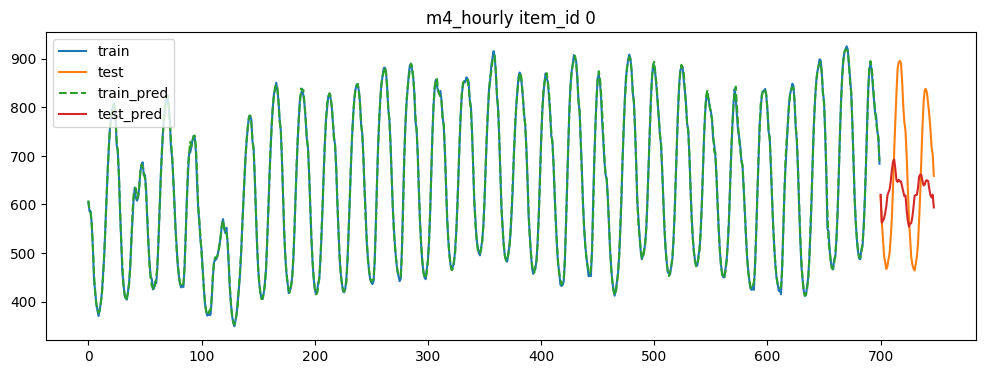

Evaluating on m4_hourly item_id 1


Training + Prediction Passes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.55batch/s]


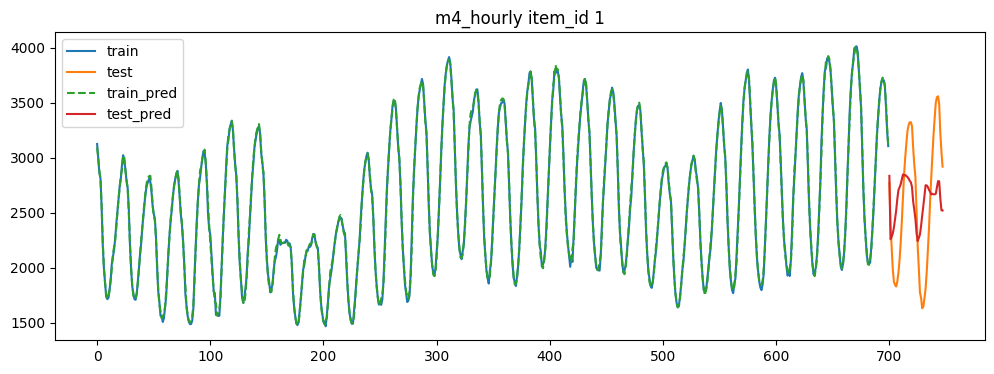

Evaluating on m4_weekly item_id 0


Training + Prediction Passes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:17<00:00,  2.19s/batch]


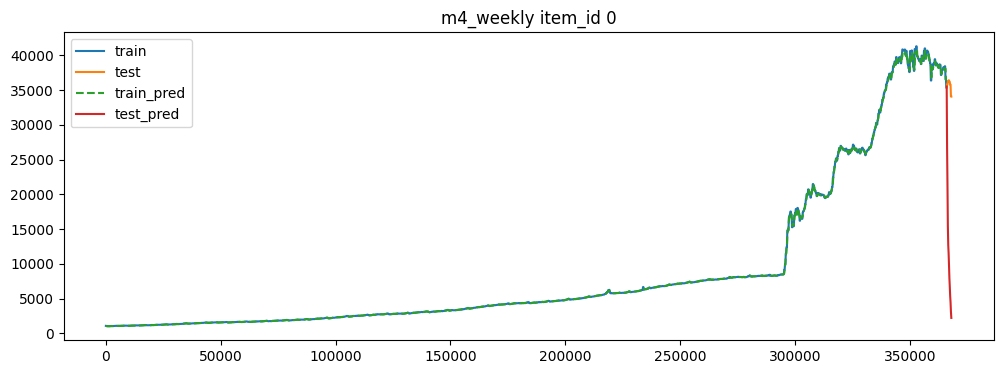

Evaluating on m4_weekly item_id 1


Training + Prediction Passes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:12<00:00,  1.59s/batch]


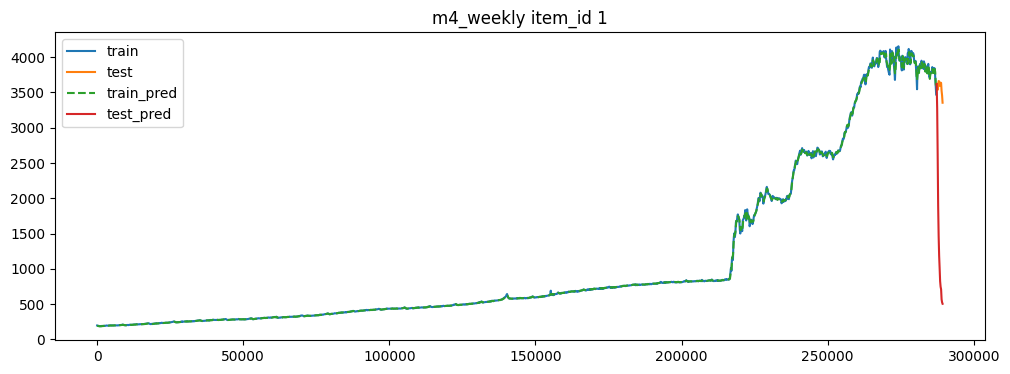

Evaluating on covid_deaths item_id 0


Training + Prediction Passes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.08batch/s]


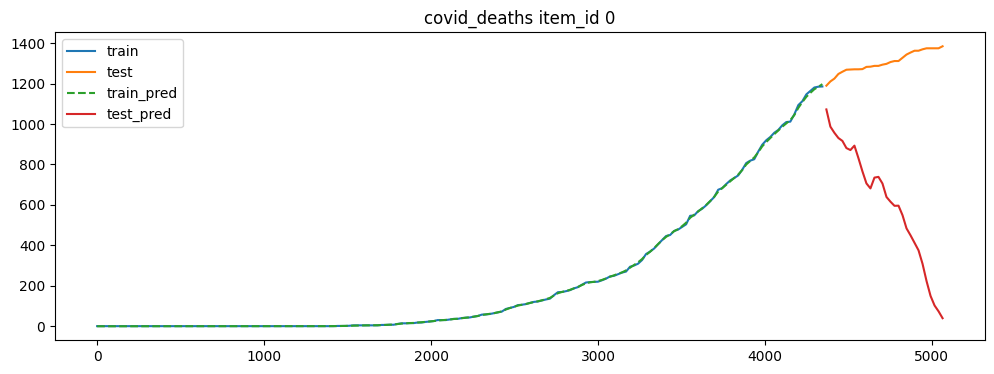

Evaluating on covid_deaths item_id 1


Training + Prediction Passes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.07batch/s]


In [24]:
evaluate(add_time_series_feature)